## Extremely Randomised Trees

Predict SFHs using ERT

In [1]:
import numpy as np
import pickle as pcl

from methods.training import load_data

from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

Using TensorFlow backend.


In [2]:
from predict import predict

si = predict(fname='data/full_histories_illustris.h5')
si.training_mask()
si.filename

'data/full_histories_illustris.h5'

In [10]:
key = 'Intrinsic'
si.generate_standardisation(key)
features = si.prepare_features(key=key, CNN=True)
predictors = si.load_arr('log_8','SFH')

In [11]:
ERT = ExtraTreeRegressor(criterion='mse')
ERT.get_params()

{'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'random'}

In [12]:
parameters = {
                'min_samples_split': [4,5,6,7,8,10],
                'min_samples_leaf': [4, 5, 6, 7, 8],
                'max_leaf_nodes': [80, 110, 120, 130, 140]
             }

# parameters = clf.best_params_

$SMAPE = 2 \times \frac{\Sigma \, |Y_{true} \,-\, Y_{pred}|}{\Sigma \, (Y_{true} \,+\, Y_{pred})}$

In [13]:
def custom_SMAPE(y_true, y_pred):
    return np.mean(si._SMAPE(y_true, y_pred))

In [14]:
scorer = make_scorer(custom_SMAPE, greater_is_better=False)

features = np.squeeze(features)

clf = GridSearchCV(ERT, param_grid=parameters, scoring=scorer)
clf.fit(X = features[si.train], y=predictors[si.train])
clf.best_params_

/research/astro/highz/Students/Chris/Learning_SFHs/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_leaf_nodes': 140, 'min_samples_leaf': 7, 'min_samples_split': 6}

In [15]:
ERT = clf.best_estimator_
prediction = ERT.predict(features[~si.train])
print("%0.3f percent"%(100 * scorer(ERT, features[~si.train], predictors[~si.train]) * -1))
# print("%0.3f percent"%(scorer(ERT, features[~sp.train], predictors[~sp.train])))

20.690 percent


In [16]:
pcl.dump(clf, open('data/ert_trained_intrinsic.p', 'wb'))

## Learning curves

In [16]:
from sklearn.model_selection import learning_curve, ShuffleSplit

cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)

train_sizes=np.linspace(.1, 1.0, 5)

train_sizes, train_scores, test_scores = learning_curve(ERT, features[sp.train], predictors[sp.train], cv=cv, 
                                                        n_jobs=2, train_sizes=train_sizes, scoring=scorer)

train_scores *= -1
test_scores *= -1

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

/home/c/cl/cl478/.conda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


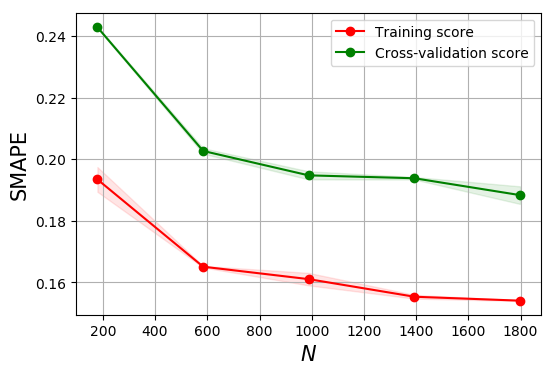

In [13]:
fig = plt.figure(dpi=100)

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")

plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")

plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")

plt.xlabel('$N$', size=15)
plt.ylabel('SMAPE', size=15)
# plt.ylabel('$R^{2}$', size=15)

# fig.savefig('plots/ert_learning_curves.png', dpi=200, bbox_inches='tight')